In [ ]:
import glob
import os.path 
import cv2
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from tqdm import tqdm
#from skimage.color import gray2rgb
#from skimage.io import imsave, imread

import pandas as pd

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [ ]:
"""

!pip install segmentation_models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
"""

In [ ]:
# https://www.kaggle.com/c/ultrasound-nerve-segmentation/data?select=train

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605806285&Signature=CUlnNbRO7qk%2BYkEGG4tqiTIV0VwaYUyUBUTZ9NAKndhV%2F8hR%2FzBh2p3CmFsaykfObHxhWYlExbE5lyXx78stpE326wFl97SUZ8XQv46Sx%2BVGfQWJ%2BECe4q70eKr%2Fzovk0%2BXnQxjIkEghx6J7VHknBrm11vFrnSWe%2BVD75qtTNU4M%2BLyOLuWgNo%2FYKDH2PochcdVllUphDFWSIab4g%2BrZIHWsCHspkhIKjLvXuLK1dDjCEptskmqa1vO9ef7VFgH0Ui9gJ3%2BoZCokfu0g9%2BUO0O9Ro6BjXl%2FJxarTXIK3eup4gKSkGVJtVnyikCzG716u1wGWBQtfyP6gxvMgpEVTeQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip" -c -O 'train.zip'

--2020-11-16 17:18:19--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605806285&Signature=CUlnNbRO7qk%2BYkEGG4tqiTIV0VwaYUyUBUTZ9NAKndhV%2F8hR%2FzBh2p3CmFsaykfObHxhWYlExbE5lyXx78stpE326wFl97SUZ8XQv46Sx%2BVGfQWJ%2BECe4q70eKr%2Fzovk0%2BXnQxjIkEghx6J7VHknBrm11vFrnSWe%2BVD75qtTNU4M%2BLyOLuWgNo%2FYKDH2PochcdVllUphDFWSIab4g%2BrZIHWsCHspkhIKjLvXuLK1dDjCEptskmqa1vO9ef7VFgH0Ui9gJ3%2BoZCokfu0g9%2BUO0O9Ro6BjXl%2FJxarTXIK3eup4gKSkGVJtVnyikCzG716u1wGWBQtfyP6gxvMgpEVTeQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.9.208, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148179100 (1.1G) [application/zip]
Saving to: ‘train.zip’

train.zip           

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/compressed/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605806304&Signature=CjAk2j6ANge92iS%2FDJhjLNR%2BYF0aopI4UqZ8ZUnrBwZdERwSswi5vgONIDJRmIsgqXsW090SLZ46Us74Shhd5zBOL6XYctvYxYF8VVqaVvCLkXlQdHhskCGZRWuTvYmYjalkCIperp2pq8VH%2BuE0UtPjT2iPnpKMW4DP7KrKQPQ8w%2BMwyp9ELdVJBxQIPuLACop2jo9f5la35q6rxPJHKVTS2P7dMdz2Q2opSxro5rGSSm139M3sPnlswpSCMMUMp%2BVZcNWukHhLfiIbLRsvz1sAeibf5ZVcdSXiKw36LZM0ulwGJtXsqjR558jAjvCmQPG%2BhZ5VtJx8gNxTLlUDKw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.zip" -c -O 'test.zip'

--2020-11-16 17:18:38--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/compressed/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605806304&Signature=CjAk2j6ANge92iS%2FDJhjLNR%2BYF0aopI4UqZ8ZUnrBwZdERwSswi5vgONIDJRmIsgqXsW090SLZ46Us74Shhd5zBOL6XYctvYxYF8VVqaVvCLkXlQdHhskCGZRWuTvYmYjalkCIperp2pq8VH%2BuE0UtPjT2iPnpKMW4DP7KrKQPQ8w%2BMwyp9ELdVJBxQIPuLACop2jo9f5la35q6rxPJHKVTS2P7dMdz2Q2opSxro5rGSSm139M3sPnlswpSCMMUMp%2BVZcNWukHhLfiIbLRsvz1sAeibf5ZVcdSXiKw36LZM0ulwGJtXsqjR558jAjvCmQPG%2BhZ5VtJx8gNxTLlUDKw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.7.144, 172.217.7.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1116759118 (1.0G) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[==================

In [ ]:
!unzip train.zip
! mkdir train
! mv *.tif train/


In [ ]:
! unzip test.zip
! mkdir test
! mv *.tif test/


### Basic EDA/ Plotting

In [ ]:
ultrasonic_images=[]

for images in glob.glob("train/*.tif"):
    if "mask" not in images:
        ultrasonic_images.append(images)
 
        

In [ ]:
def image_to_mask(img_path):
    # convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(img_path)
    maskname = basename.replace(".tif", "_mask.tif")
    return os.path.join(dirname, maskname)

In [ ]:
mask_images=[image_to_mask(img) for img in ultrasonic_images]

In [ ]:
def image_with_mask(img, mask):
  # to add the mask on the image with outer layer in green
    img = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0  
    img[mask_edges, 0] = 0  
    img[mask_edges, 1] = 255 #Making green colour mask
    img[mask_edges, 2] = 0
    return img


In [ ]:
def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img)) 

train/33_76.tif
train/33_76_mask.tif


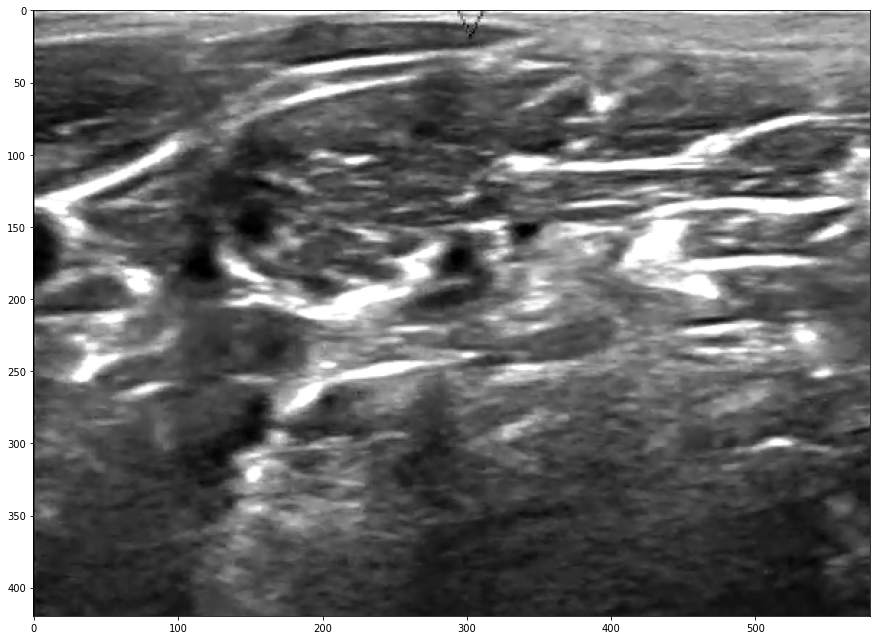

train/29_31.tif
train/29_31_mask.tif


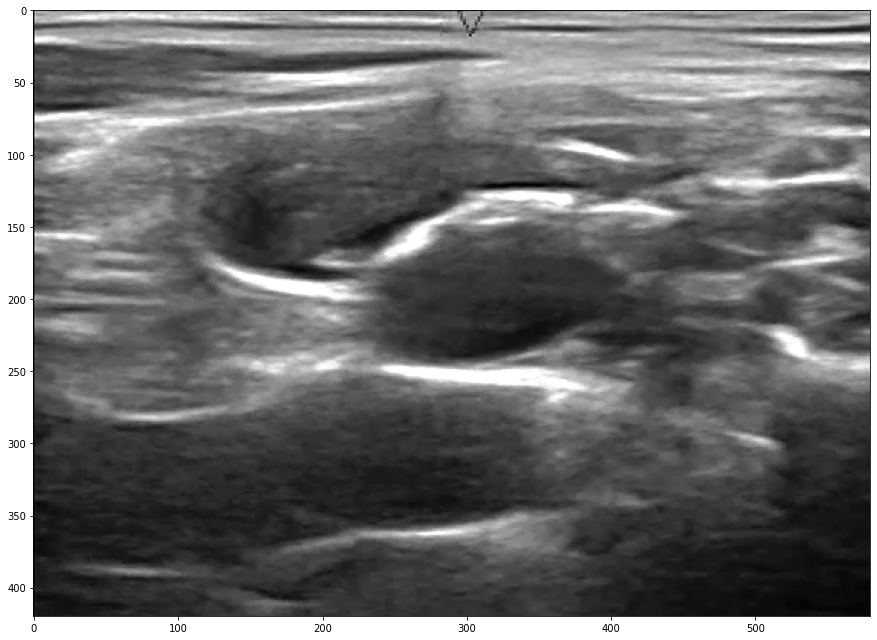

train/38_59.tif
train/38_59_mask.tif


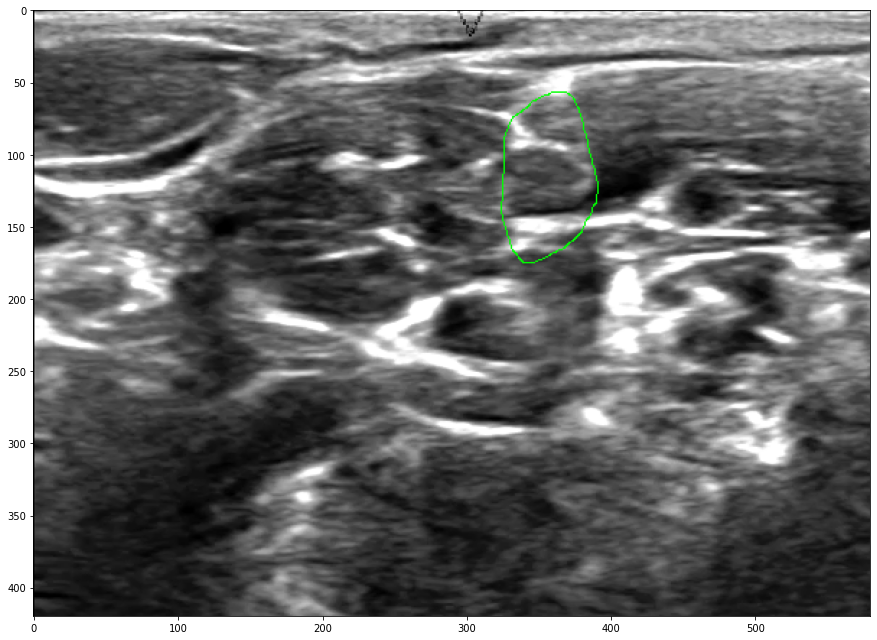

train/22_2.tif
train/22_2_mask.tif


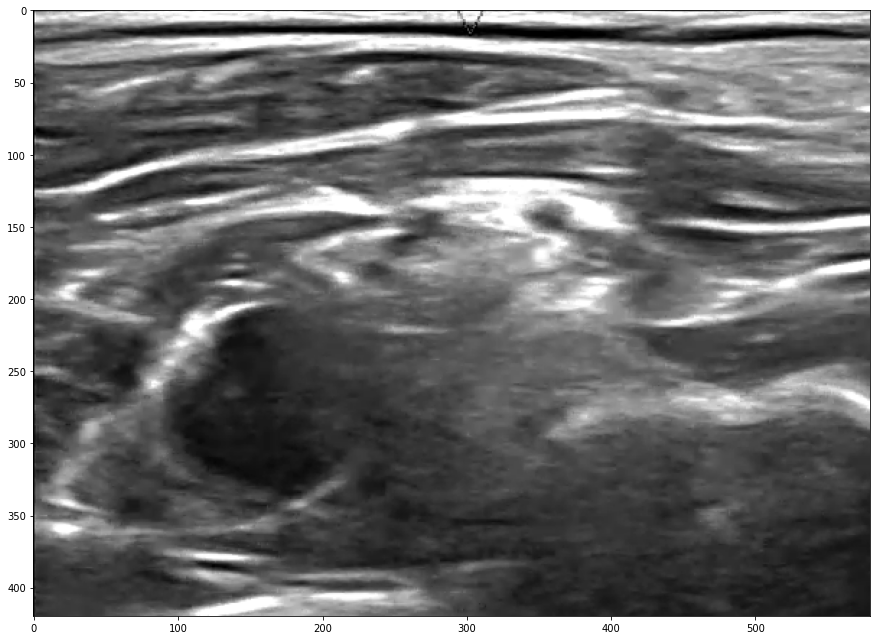

In [ ]:
count=0

for f_ultrasound, f_mask in zip(ultrasonic_images, mask_images):
    
    print(f_ultrasound)
    print(f_mask)

    img  = plt.imread(f_ultrasound)
    mask = plt.imread(f_mask)

    plt.figure(figsize=(15,20))
    
    plt.imshow(image_with_mask(img, mask))

    plt.show()
    
    if count==3:
        break;
                                
    count=count+1
    
    



Observation:
    1. In many Ultrasonic images there is no Brachial plexus nerve located. 
    2. Model should correctly identify the brachial plexus nerver and if it is not located model should predict no pixels.
    

train/33_76.tif


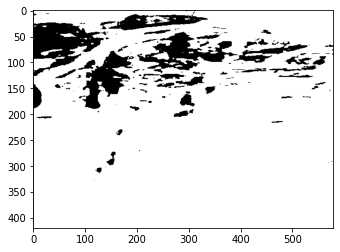

Mask corresponding to  train/33_76.tif


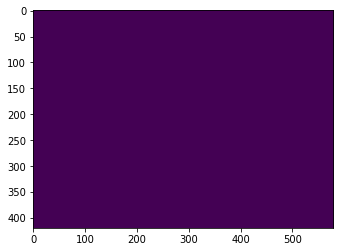

train/29_31.tif


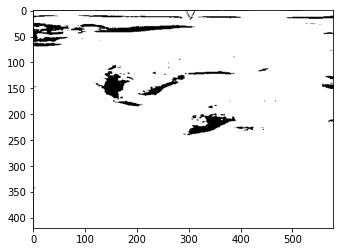

Mask corresponding to  train/29_31.tif


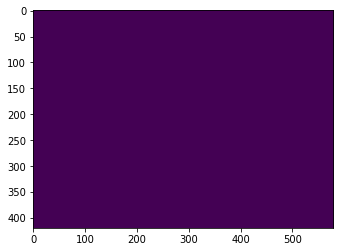

train/38_59.tif


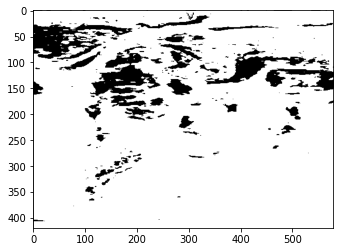

Mask corresponding to  train/38_59.tif


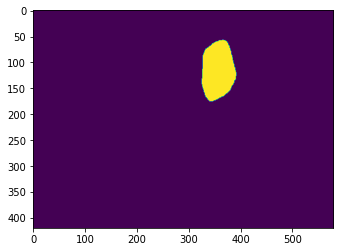

train/22_2.tif


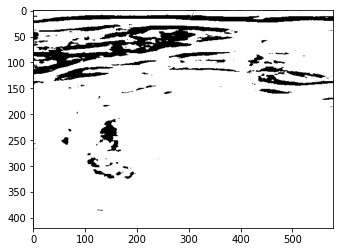

Mask corresponding to  train/22_2.tif


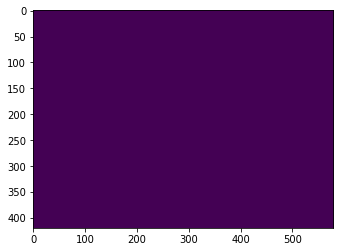

train/29_68.tif


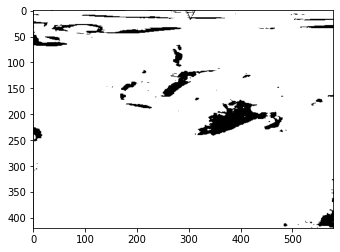

Mask corresponding to  train/29_68.tif


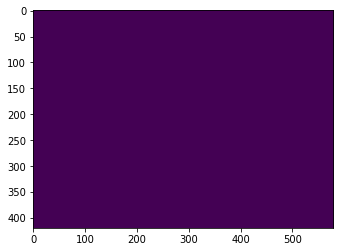

In [ ]:
count=0
for f_ultrasound, f_mask in zip(ultrasonic_images, mask_images):
    image=plt.imread(f_ultrasound)
    mask=plt.imread(f_mask)
    image_c = image.reshape(image.shape[0]*image.shape[1])
    image_r=image_c.copy()
    for i in range(image_r.shape[0]):
        if image_r[i] > image_r.mean() :
            image_r[i] = 1
        else:
            image_r[i] = 0
    image = image_r.reshape(image.shape[0],image.shape[1])
    print(f_ultrasound)
    plt.imshow(image, cmap='gray')
    plt.show()
    print("Mask corresponding to ", f_ultrasound)
    plt.imshow(mask)
    plt.show()
    count=count+1
    if(count==5):
        break;

train/33_76.tif


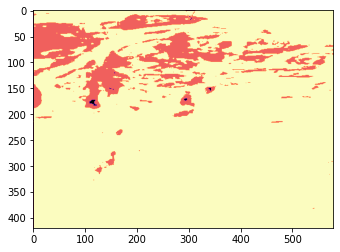

Mask corresponding to  train/33_76.tif


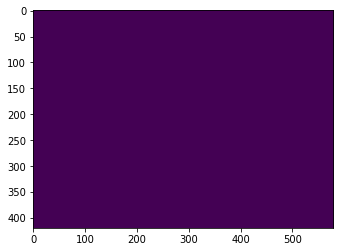

train/29_31.tif


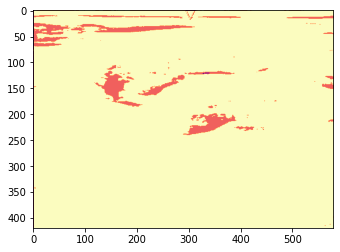

Mask corresponding to  train/29_31.tif


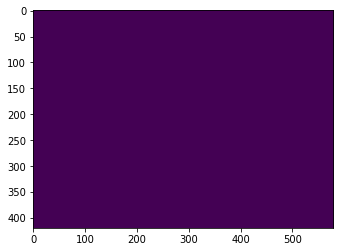

train/38_59.tif


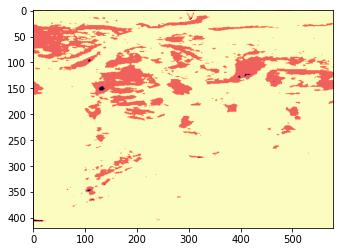

Mask corresponding to  train/38_59.tif


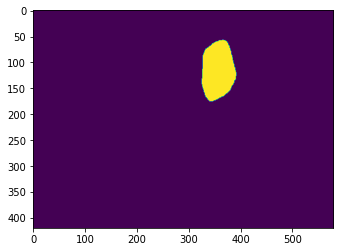

train/22_2.tif


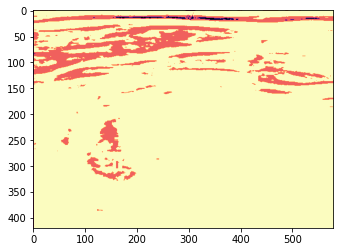

Mask corresponding to  train/22_2.tif


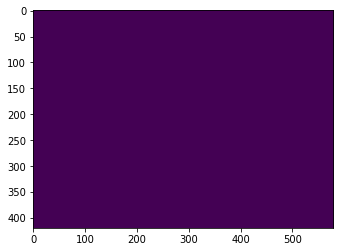

train/29_68.tif


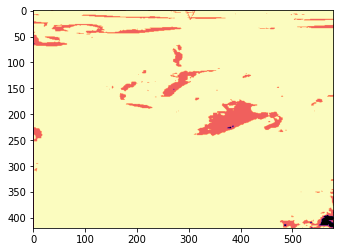

Mask corresponding to  train/29_68.tif


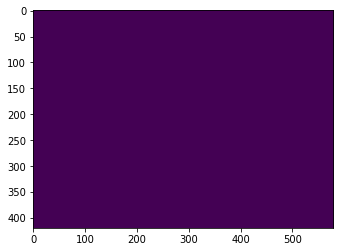

In [ ]:
count=0
for f_ultrasound, f_mask in zip(ultrasonic_images, mask_images):
    image=plt.imread(f_ultrasound)
    mask=plt.imread(f_mask)
    image_c = image.reshape(image.shape[0]*image.shape[1])
    image_r=image_c.copy()
    for i in range(image_r.shape[0]):
        if image_r[i] > image_r.mean()+0.25:
            image_r[i] = 3
        elif image_r[i] > 0.5:
            image_r[i] = 2
        elif image_r[i] > 0.25:
            image_r[i] = 1
        else:
            image_r[i] = 0
    image = image_r.reshape(image.shape[0],image.shape[1])
    print(f_ultrasound)
    plt.imshow(image, cmap='magma')
    plt.show()
    print("Mask corresponding to ", f_ultrasound)
    plt.imshow(mask)
    plt.show()
    count=count+1
    if(count==5):
        break;

In [ ]:
train_rle=pd.read_csv('train_masks.csv')

In [ ]:
train_rle.head()

subject  img                                             pixels
0        1    1  168153 9 168570 15 168984 22 169401 26 169818 ...
1        1    2  96346 7 96762 16 97179 27 97595 35 98012 40 98...
2        1    3  121957 2 122365 26 122784 28 123202 31 123618 ...
3        1    4  110980 9 111393 21 111810 33 112228 43 112647 ...
4        1    5                                                NaN

In [ ]:
pixels=train_rle['pixels'].values
print(pixels[0])
start_position = [] # Run-start pixel locations
run_length = [] # Run-lengths
nan_images=[]
non_nan_images=[]

# Separate run-lengths and pixel locations into seperate lists
for p in pixels:
    x = str(p).split(' ')
    i = 0
    for m in x:
        if i % 2 == 0:
            start_position.append(m)
        else:
            run_length.append(m)
        i += 1

# Remove NaNs

i = 0
for p in start_position:
    if p == 'nan':
        i += 1
    else:
        non_nan_images.append(p)
  

print('\nNumber of NaN in pixel locations: ' + str(i))

168153 9 168570 15 168984 22 169401 26 169818 30 170236 34 170654 36 171072 39 171489 42 171907 44 172325 46 172742 50 173159 53 173578 54 173997 55 174416 56 174834 58 175252 60 175670 62 176088 64 176507 65 176926 66 177345 66 177764 67 178183 67 178601 69 179020 70 179438 71 179857 71 180276 71 180694 73 181113 73 181532 73 181945 2 181950 75 182365 79 182785 79 183205 78 183625 78 184045 77 184465 76 184885 75 185305 75 185725 74 186145 73 186565 72 186985 71 187405 71 187825 70 188245 69 188665 68 189085 68 189506 66 189926 65 190346 63 190766 63 191186 62 191606 62 192026 61 192446 60 192866 59 193286 59 193706 58 194126 57 194546 56 194966 55 195387 53 195807 53 196227 51 196647 50 197067 50 197487 48 197907 47 198328 45 198749 42 199169 40 199589 39 200010 35 200431 33 200853 29 201274 27 201697 20 202120 15 202544 6

Number of NaN in pixel locations: 3312


In [ ]:
len(non_nan_images)
len(start_position)

219781

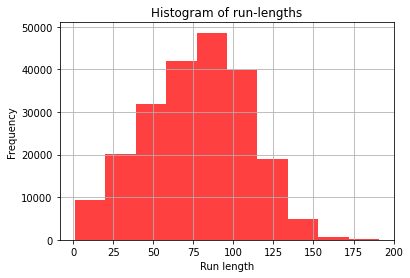

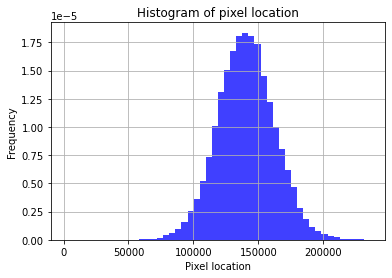

In [ ]:
import matplotlib.pyplot as plt

p = np.array(run_length).astype(int)
plt.hist(p,facecolor='red', alpha=0.75)
plt.title('Histogram of run-lengths')
plt.xlabel('Run length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

p = np.array(non_nan_images).astype(int)
plt.hist(p, 50, density=1, facecolor='blue', alpha=0.75)
plt.title('Histogram of pixel location')
plt.xlabel('Pixel location')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Basic Model 

In [ ]:
# Creating train data to pass to the model

ultrasonic_images_count=0
mask_images_count=0


for image in glob.glob("train/*.tif"):
    if 'mask' not in image:
        ultrasonic_images_count+=1
    else:
        mask_images_count+=1
        
print(ultrasonic_images_count)
print(mask_images_count)


rows=420
columns=580
    
ultra_son_images=np.ndarray((ultrasonic_images_count, rows, columns) ,dtype=np.uint8)
ultra_son_masks=np.ndarray((mask_images_count, rows, columns),  dtype=np.uint8)

images=os.listdir("train/")
i=0

for image in tqdm(images):
    if 'mask' not in image:
        mask_name=image.split('.')[0]+'_mask.tif'
        image_name=image
        
        ultra_son_image=cv2.imread(os.path.join("train/",image_name),0)
        ultra_son_mask=cv2.imread(os.path.join("train/", mask_name),0)
        
        ultra_son_image = np.array([ultra_son_image])
        ultra_son_mask = np.array([ultra_son_mask])
        
        

        ultra_son_images[i] = ultra_son_image
        ultra_son_masks[i] = ultra_son_mask
        
        i=i+1

    
        


  1%|          | 64/11270 [00:00<00:18, 621.20it/s]

5635
5635


100%|██████████| 11270/11270 [00:25<00:00, 442.29it/s]


In [ ]:
from numpy import save

save('ultrasonic_images_data.npy', ultra_son_images)
save('ultrasonic_masks_data.npy', ultra_son_masks)

In [ ]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [ ]:
dice_loss= sm.losses.DiceLoss()

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred= tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2.0 * intersection) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred))


In [ ]:
tf.keras.backend.clear_session()

img_rows = 128
img_cols = 128

def create_model():
    inputs = Input((img_rows, img_cols, 1))

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)




    up1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)


    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])

    model.compile(optimizer=Adam(lr=0.00001), loss=dice_loss, metrics=[dice_coef])

    return model


model=create_model()

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

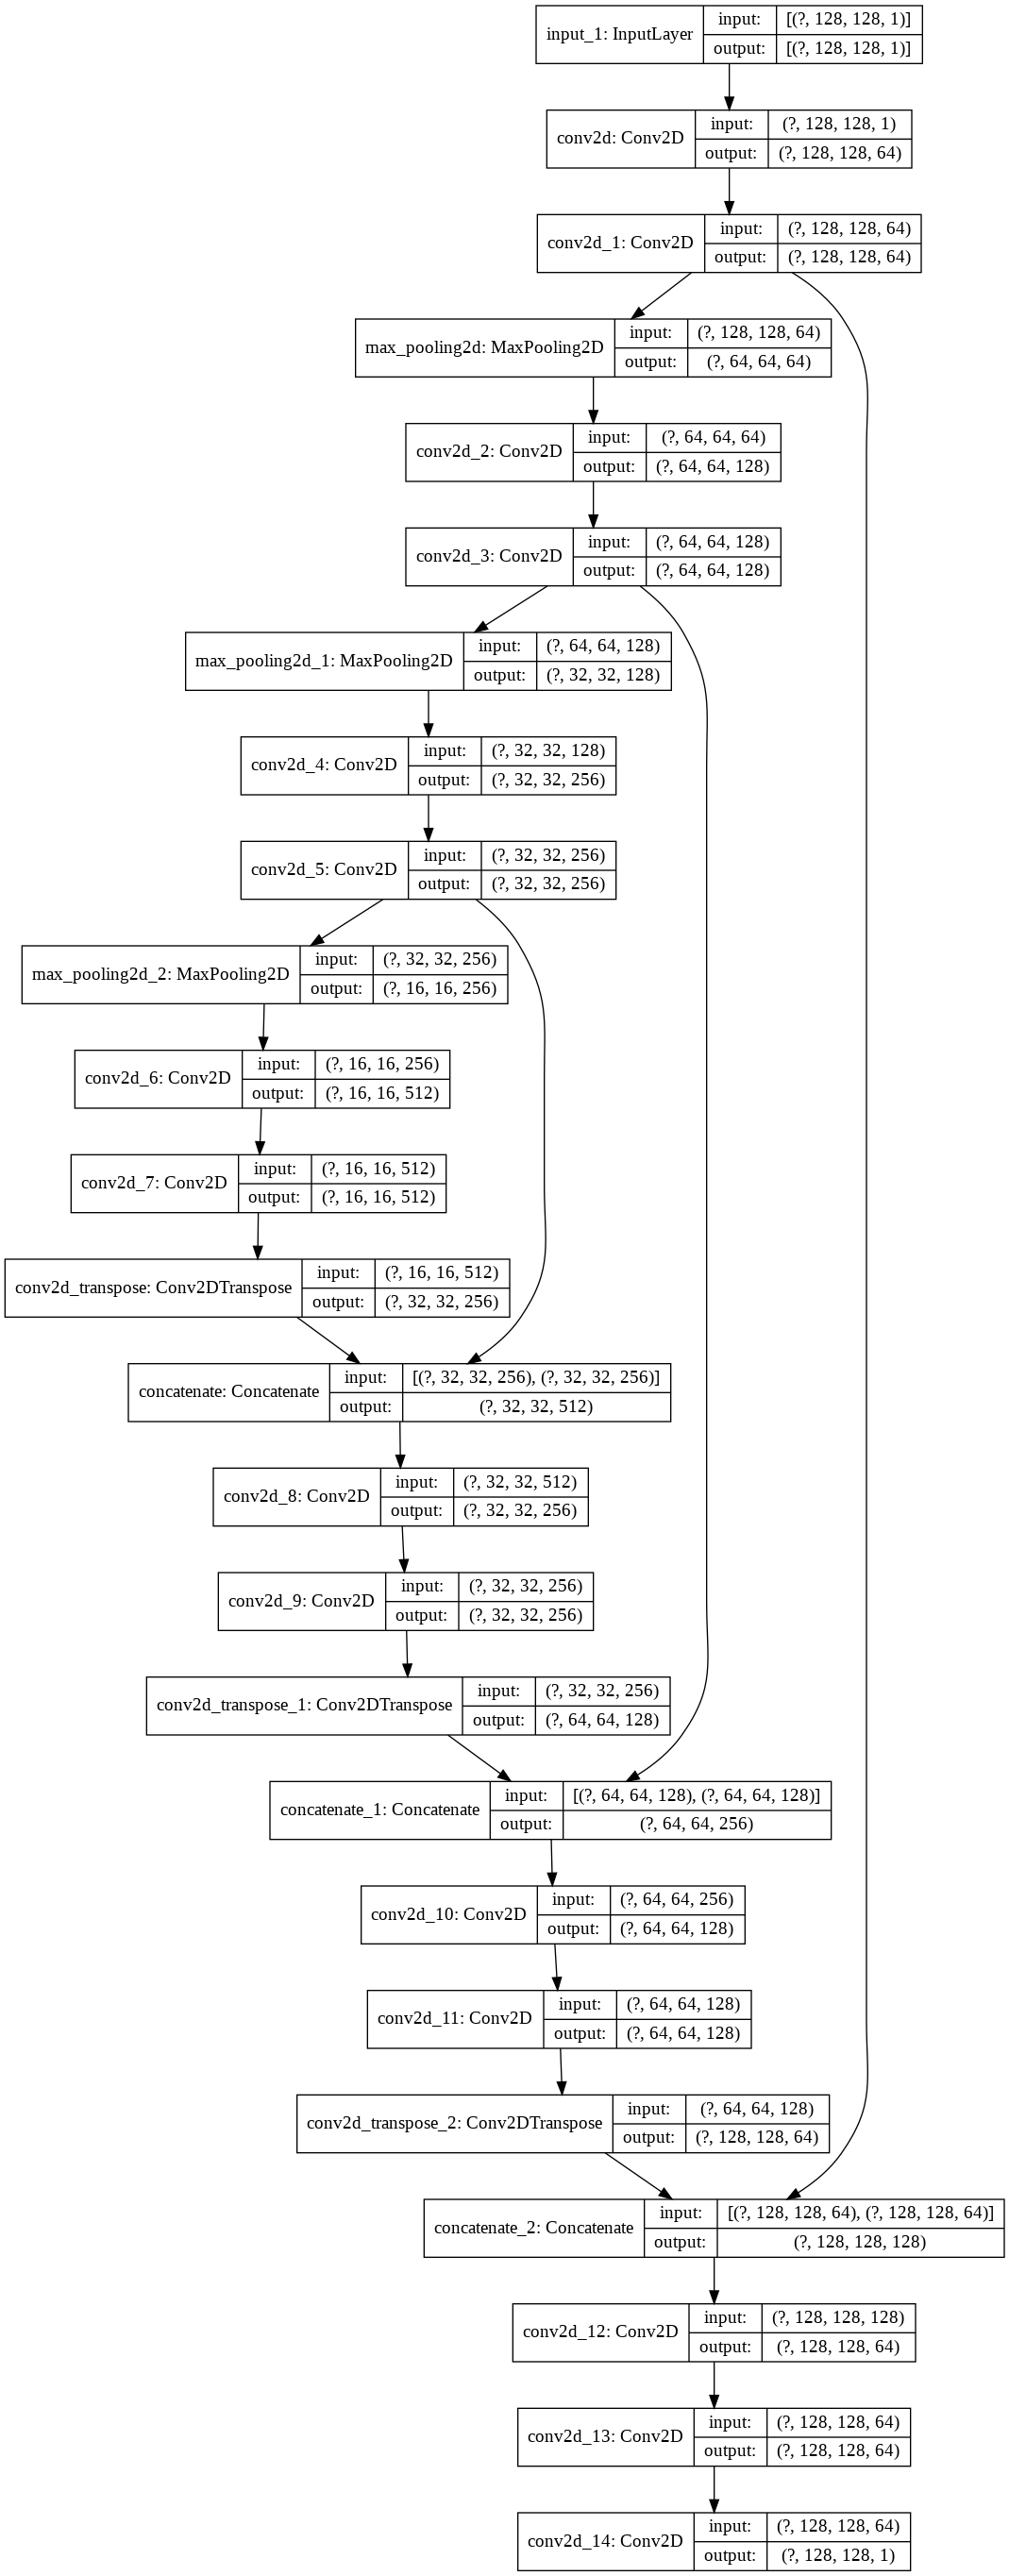

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
import datetime

ultra_son_images=np.load('ultrasonic_images_data.npy')
ultra_son_masks= np.load('ultrasonic_masks_data.npy')


imgs= preprocess(ultra_son_images)
imgs_mask = preprocess(ultra_son_masks)


imgs = imgs.astype('float32')

imgs_train=imgs[:4800]

mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train=imgs_mask[:4800]
imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

imgs_validation= imgs[4800:]
imgs_validation -= mean
imgs_validation /= std


imgs_mask_validation = imgs_mask[4800:]
imgs_mask_validation = imgs_mask_validation.astype('float32')
imgs_mask_validation /= 255.  # scale masks to [0, 1]

In [ ]:
print(imgs_train.shape)
print(imgs_mask_train.shape)
print(imgs_validation.shape)
print(imgs_mask_validation.shape)


(4800, 128, 128, 1)
(4800, 128, 128, 1)
(835, 128, 128, 1)
(835, 128, 128, 1)


In [ ]:
#tensorboard

!rm -r logs*

log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

model_checkpoint = ModelCheckpoint('Model_weights.h5', monitor='val_loss', save_best_only=True)

callback_list = [tensorboard_callback,model_checkpoint]

model.fit(x=imgs_train, y=imgs_mask_train, batch_size=32, epochs=30, verbose=1, shuffle=True,
              validation_data= [imgs_validation, imgs_mask_validation],
              callbacks=callback_list)

rm: cannot remove 'logs*': No such file or directory
Train on 4800 samples, validate on 835 samples
Epoch 1/30
4800/4800 [==============================] - 66s 14ms/sample - loss: 0.9752 - dice_coef: 0.0248 - val_loss: 0.9721 - val_dice_coef: 0.0270
Epoch 2/30
4800/4800 [==============================] - 54s 11ms/sample - loss: 0.9087 - dice_coef: 0.0913 - val_loss: 0.8391 - val_dice_coef: 0.1555
Epoch 3/30
4800/4800 [==============================] - 53s 11ms/sample - loss: 0.6949 - dice_coef: 0.3051 - val_loss: 0.6891 - val_dice_coef: 0.3005
Epoch 4/30
4800/4800 [==============================] - 53s 11ms/sample - loss: 0.6389 - dice_coef: 0.3611 - val_loss: 0.6123 - val_dice_coef: 0.3746
Epoch 5/30
4800/4800 [==============================] - 54s 11ms/sample - loss: 0.6065 - dice_coef: 0.3935 - val_loss: 0.5771 - val_dice_coef: 0.4087
Epoch 6/30
4800/4800 [==============================] - 53s 11ms/sample - loss: 0.5616 - dice_coef: 0.4384 - val_loss: 0.5891 - val_dice_coef: 0.3971


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs\\fit\\20201116-173302

<IPython.core.display.Javascript object>

In [ ]:
# Creating train data to pass to the model

test_images_count=len(os.listdir('test'))

rows=420
columns=580
    
test_images=np.ndarray((test_images_count, rows, columns) ,dtype=np.uint8)
test_ids=[]



test_us_images=os.listdir("test/")

i=0

for image in tqdm(test_us_images):

    img_id = int(image.split('.')[0])
 
    test_image=cv2.imread(os.path.join("test/",image),0)
    test_image = np.array([test_image])
    
    test_images[i] = test_image
    test_ids.append(img_id)
    i=i+1

test_ids=np.array(test_ids)    
np.save('test_ids.npy', test_ids)
np.save('test_data.npy', test_images)
    
        


100%|██████████| 5508/5508 [00:33<00:00, 166.38it/s]


In [ ]:

test_images=np.load('test_data.npy')
test_ids=np.load('test_ids.npy')

imgs_test = preprocess(test_images)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std


model.load_weights('Model_weights.h5')


imgs_mask_test = model.predict(imgs_test, verbose=1)

pred_dir = 'preds'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for image, image_id in zip(imgs_mask_test, test_ids):
    image = (image[:, :, 0] * 255.).astype(np.uint8)
    imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)
np.save('imgs_mask_test.npy', imgs_mask_test)

In [ ]:
# Submission format 

from __future__ import print_function

import numpy as np
from skimage.transform import resize


image_rows = 420
image_cols = 580


def prep(img):
    img = img.astype('float32')
    img = (img > 0.5)
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img


def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])


def submission():

    imgs_test = np.load('imgs_mask_test.npy')
    imgs_id_test=np.load('test_ids.npy')

    argsort = np.argsort(imgs_id_test)
    imgs_id_test = imgs_id_test[argsort]
    imgs_test = imgs_test[argsort]

    total = imgs_test.shape[0]
    ids = []
    rles = []
    for i in range(total):
        img = imgs_test[i, :, :, 0]
        img = prep(img)
        rle = run_length_enc(img)

        rles.append(rle)
        ids.append(imgs_id_test[i])

        if i % 100 == 0:
            print('{}/{}'.format(i, total))

    first_row = 'img,pixels'
    file_name = 'submission_kaggle.csv'

    with open(file_name, 'w+') as f:
        f.write(first_row + '\n')
        for i in range(total):
            s = str(ids[i]) + ',' + rles[i]
            f.write(s + '\n')




In [ ]:
submission()

0/5508
100/5508
200/5508
300/5508
400/5508
500/5508
600/5508
700/5508
800/5508
900/5508
1000/5508
1100/5508
1200/5508
1300/5508
1400/5508
1500/5508
1600/5508
1700/5508
1800/5508
1900/5508
2000/5508
2100/5508
2200/5508
2300/5508
2400/5508
2500/5508
2600/5508
2700/5508
2800/5508
2900/5508
3000/5508
3100/5508
3200/5508
3300/5508
3400/5508
3500/5508
3600/5508
3700/5508
3800/5508
3900/5508
4000/5508
4100/5508
4200/5508
4300/5508
4400/5508
4500/5508
4600/5508
4700/5508
4800/5508
4900/5508
5000/5508
5100/5508
5200/5508
5300/5508
5400/5508
5500/5508
